# 🧠 PyTorch Workflow
---
This notebook provides a comprehensive introduction to **PyTorch**, covering essential topics, theory, functions, and practical examples. 

📘 **Official Documentation**: [https://pytorch.org/docs/stable/index.html](https://pytorch.org/docs/stable/index.html)

📘 **Official Pytorch Cheatsheet**: [https://docs.pytorch.org/tutorials/beginner/ptcheat.html](https://docs.pytorch.org/tutorials/beginner/ptcheat.html)

📘 **Notebook Resource**: [https://www.learnpytorch.io/01_pytorch_workflow/](https://www.learnpytorch.io/01_pytorch_workflow/)

---

## 📑 Contents
1. Linear Regression
2. Preparing Data
3. Split Dataset
4. Visualize Dataset
4. Build Model
5. Loss Functions
6. Optimization
7. Building Training Loop
8. Building Testing Loop
9. Training
10. Evaluation
11. Saving and Loading Model
12. Summary (Whole process on GPU)


In [969]:
Workflow_in_general = {1: "data (prepare and load)",
                       2: "build model",
                       3: "fitting the model to data (training)",
                       4: "making predictions and evaluating model (inference)",
                       5: "saving and loading a model",
                       6: "putting all together" 
                        }

Workflow_in_general

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating model (inference)',
 5: 'saving and loading a model',
 6: 'putting all together'}

In [970]:
import torch
from torch import nn ## nn contains all of PyTorch's building block
import matplotlib.pyplot as plt

# Linear Regression

Let's define some parameters and try to fit the line

In [971]:
# Known Parameters

weight = 0.7
bias = 0.3

## Preparing Data

In [972]:
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y), X.shape

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50,
 torch.Size([50, 1]))

## Splitting Dataset (Train, Test)

In [973]:
train_split = int(0.8 * len(X))
train_split

40

In [974]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

## Visualizing the Dataset

In [975]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    
    """
    Plots training data, test data and compares predictions.
    """

    plt.figure(figsize=(10,7))

    # Plot training in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")


    # Plot training in blue
    plt.scatter(test_data, test_labels, c='g', s=4, label="Testing data")

    if predictions is not None:

        # plot predictions if exist
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")

    plt.legend(prop={"size":14})


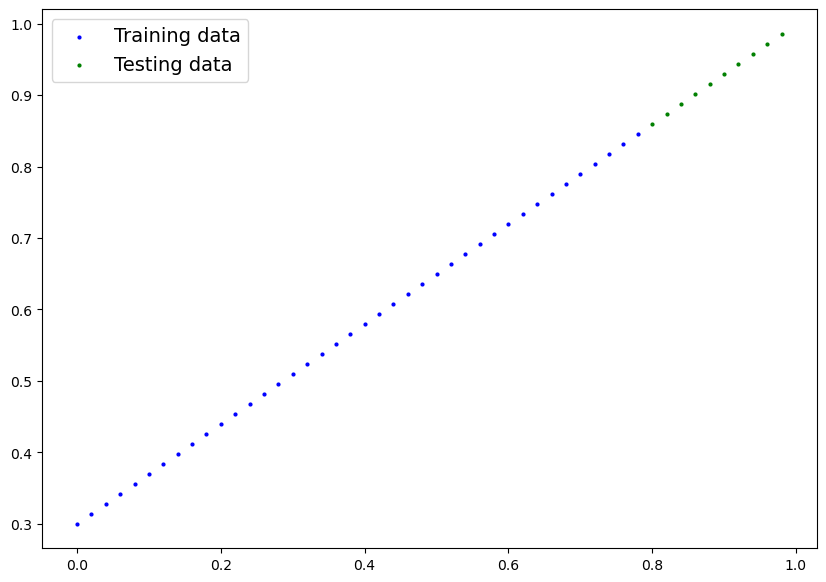

In [976]:
plot_predictions()

# PyTorch model building essentials

- `torch.nn`	Contains all of the building blocks for computational graphs (Neural Network) (essentially a series of computations executed in a particular way).
- `torch.nn.Module` 	The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass nn.Module. Requires a forward() method be implemented.
- `torch.nn.Parameter` 	Stores tensors that can be used with nn.Module. If requires_grad=True gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as "autograd".
- `torch.optim` 	Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss). 
- `def forward()` 	All nn.Module subclasses require a forward() method, this defines the computation that will take place on the data passed to the particular nn.Module (e.g. the linear regression formula above).

# Build Model

- create custom class (subclass nn.module)
- create __init__ method, initialize parameters randomly - keep requires_grad = True for trainable parameters
- create forward method
- 

In [977]:
# Create Linear Regression model class

class LinearRegressionModel(nn.Module):     # Almost everything in pytorch inherits from nn.module

    # Init function

    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))
        
    # Forward Method
    def forward(self, x:torch.Tensor)->torch.Tensor: # "x is the input data"
        return self.weight * x + self.bias
    #

In [978]:
# Set Seed

torch.manual_seed(42)

# Create instance of model

model_0 = LinearRegressionModel()

# List model parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making Predictions (before training)

In [979]:
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

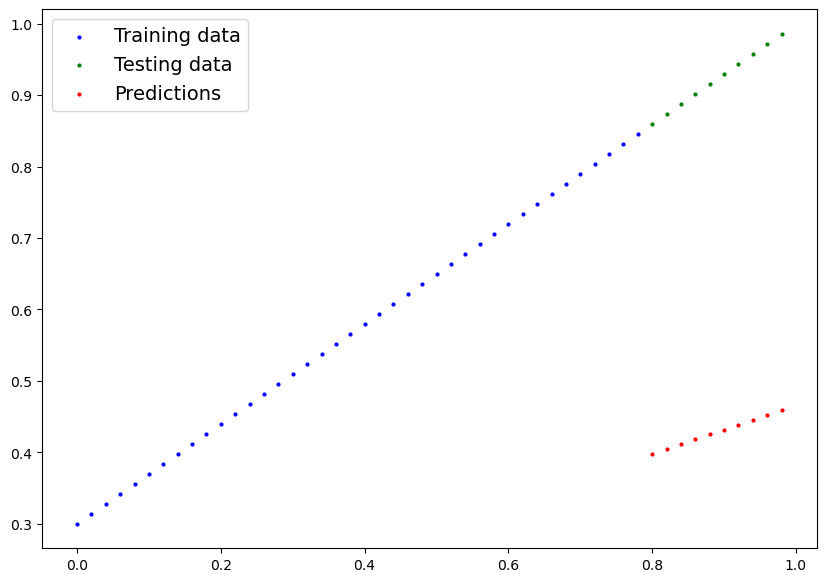

In [980]:
plot_predictions(predictions=y_preds)

# Loss Function

Measures how wrong your model's predictions (e.g. y_preds) are compared to the truth labels (e.g. y_test). Lower the better. It is also called Criterion.

In [981]:
loss_function = nn.L1Loss()

# Optimizer

Tells your model how to update its internal parameters to best lower the loss.

In [982]:
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

# Building Training Loop

- Loop through the data
- Forward Pass - (data moving through the model's forward () function)
- Calculate the loss
- Optimizer zero grad
- Loss backward - Calculate gradients of each of model parameters
- Optimizer step - use optimizer to adjust the model's parameters to reduce the loss

In [983]:
torch.manual_seed(42)

epochs = 200

train_loss_value = []
test_loss_value = []
epoch_count = []

for epoch in range(epochs):

    model_0.train() # turns on gradient tracking

    # Forward pass
    y_pred = model_0(X_train)

    # Calculate Loss
    loss = loss_function(y_pred,y_train)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backpropogation
    loss.backward()

    # Step optimizer
    optimizer.step()

    model_0.eval()

    with torch.inference_mode():
        test_pred = model_0(X_test)

        test_loss = loss_function(test_pred, y_test.type(torch.float))

    if epoch % 10 ==0:

        epoch_count.append(epoch)
        train_loss_value.append(loss.detach().numpy())
        test_loss_value.append(test_loss.detach().numpy())

        print(f"Epoch: {epoch}, | Loss: {loss}, | Test Loss: {test_loss}")
        print(model_0.state_dict())

Epoch: 0, | Loss: 0.31288138031959534, | Test Loss: 0.48106518387794495
OrderedDict({'weight': tensor([0.3406]), 'bias': tensor([0.1388])})
Epoch: 10, | Loss: 0.1976713240146637, | Test Loss: 0.3463551998138428
OrderedDict({'weight': tensor([0.3796]), 'bias': tensor([0.2388])})
Epoch: 20, | Loss: 0.08908725529909134, | Test Loss: 0.21729660034179688
OrderedDict({'weight': tensor([0.4184]), 'bias': tensor([0.3333])})
Epoch: 30, | Loss: 0.053148526698350906, | Test Loss: 0.14464017748832703
OrderedDict({'weight': tensor([0.4512]), 'bias': tensor([0.3768])})
Epoch: 40, | Loss: 0.04543796554207802, | Test Loss: 0.11360953003168106
OrderedDict({'weight': tensor([0.4748]), 'bias': tensor([0.3868])})
Epoch: 50, | Loss: 0.04167863354086876, | Test Loss: 0.09919948130846024
OrderedDict({'weight': tensor([0.4938]), 'bias': tensor([0.3843])})
Epoch: 60, | Loss: 0.03818932920694351, | Test Loss: 0.08886633068323135
OrderedDict({'weight': tensor([0.5116]), 'bias': tensor([0.3788])})
Epoch: 70, | Lo

In [984]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [985]:
# Test Code

model_0.eval()

with torch.inference_mode():
    test_pred = model_0(X_test)

    test_loss = loss_function(test_pred, y_test)

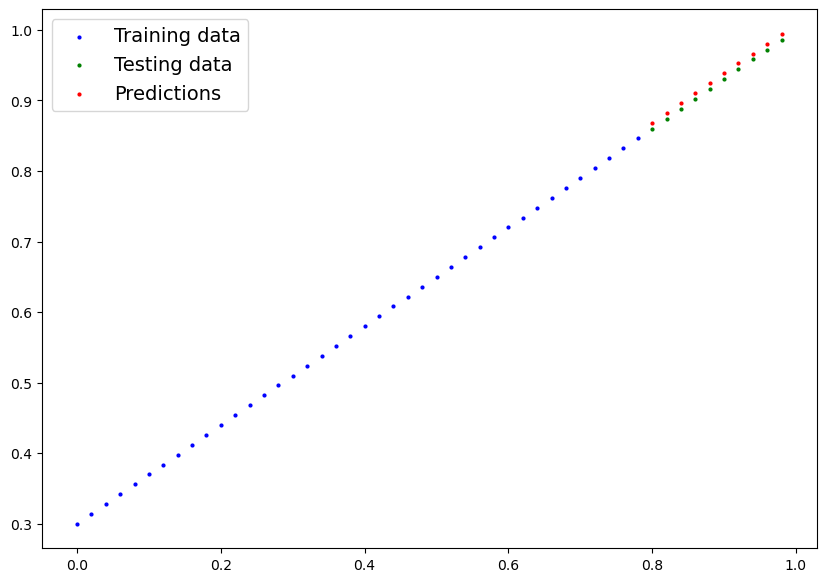

In [986]:
plot_predictions(predictions=test_pred)

Plot Loss Curves


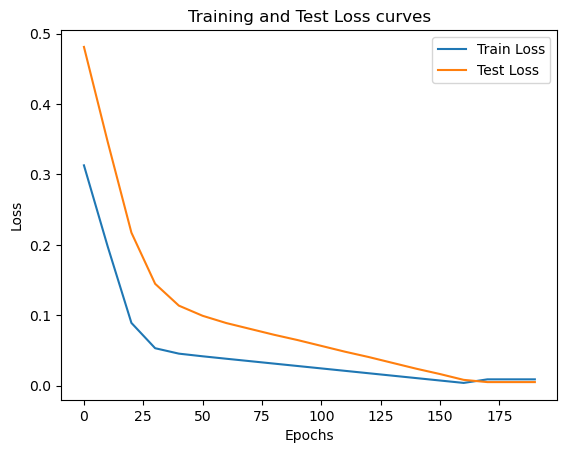

In [987]:
plt.plot(epoch_count, train_loss_value, label= "Train Loss")
plt.plot(epoch_count, test_loss_value, label= "Test Loss")
plt.title("Training and Test Loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

# Saving a Model in Pytorch

- `torch.save()` - allows you to save a Pytorch object in Python's pickle format
- `torch.load()` - allows you to load a saved Pytorch object
- `torch.nn.Module.load_state_dict()` - this allows you to load a model's saved state dictionary

In [988]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_Model_01.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

WindowsPath('models/01_Model_01.pth')

In [989]:
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\01_Model_01.pth


# Loading a Model in Pytorch

In [990]:
# To load in a saved state_dict we have to instantiate a new instance of our model class

loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [991]:
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

# Summary (Now lets summarize and put all process in one place & on GPU)

### Imports

In [1025]:
import torch
import numpy as np
import matplotlib.pyplot as plt


### Device Agnostic Code

In [1035]:
# Device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')


Using device: cuda


### Data

Lets make some data using y = mx + b to apply linear regression model


In [1036]:
weight = 0.7
bias = 0.3

# Create Range values
start = 0
end = 1
step = 0.02

# Create X and y

X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias

In [1037]:
X[:10], y [:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Split Data

In [1038]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len (X_test), len(y_test)

(40, 40, 10, 10)

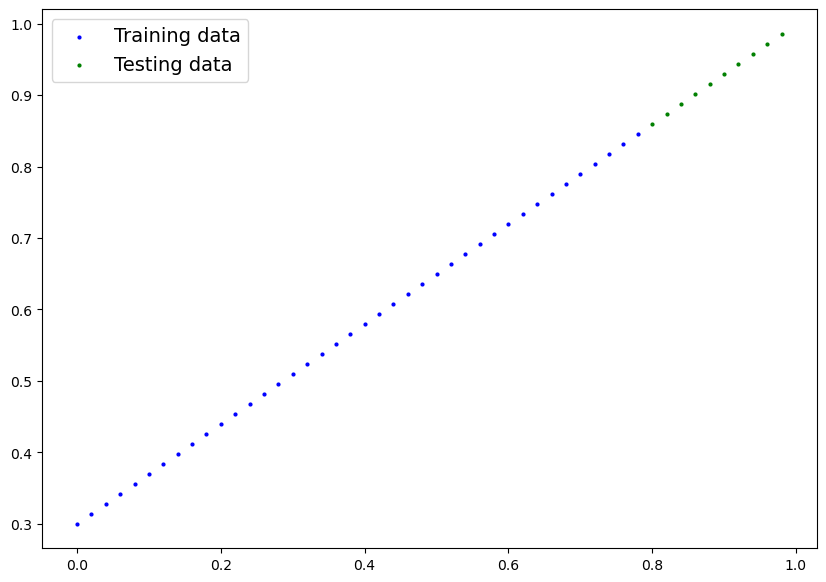

In [1039]:
plot_predictions(X_train,y_train,X_test,y_test)

### Build a Model

In [1040]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Use Linear for parameters (weights and biases)
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    
    def forward(self, x):
        return self.linear_layer(x)
    
torch.manual_seed(42)

model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()


(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [1041]:
# Check model current device

next(model_1.parameters()).device

device(type='cpu')

In [1042]:
# Transferring model to GPU
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [1043]:
X_train.shape

torch.Size([40, 1])

### Training

For training, we need:
- Loss function
- Optimizer
- Training Loop
- Testing Loop

In [1044]:
# Loss function
loss_function = nn.L1Loss()

# Optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

# Training Loop
torch.manual_seed(42)

epochs = 200

# Put data on target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    # Forward pass
    y_pred = model_1(X_train)

    # Loss
    loss = loss_function(y_pred, y_train)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backpropogation
    loss.backward()

    # Opimizer Step
    optimizer.step()

    # Testing
    model_1.eval()


    with torch.inference_mode():
        
        test_pred = model_1(X_test)

        test_loss = loss_function(test_pred, y_test)
    
    # print whats happenening

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}')


Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [1045]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### Evaluate Model

In [1048]:
model_1.eval()

with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_function(test_pred,y_test)
test_pred

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

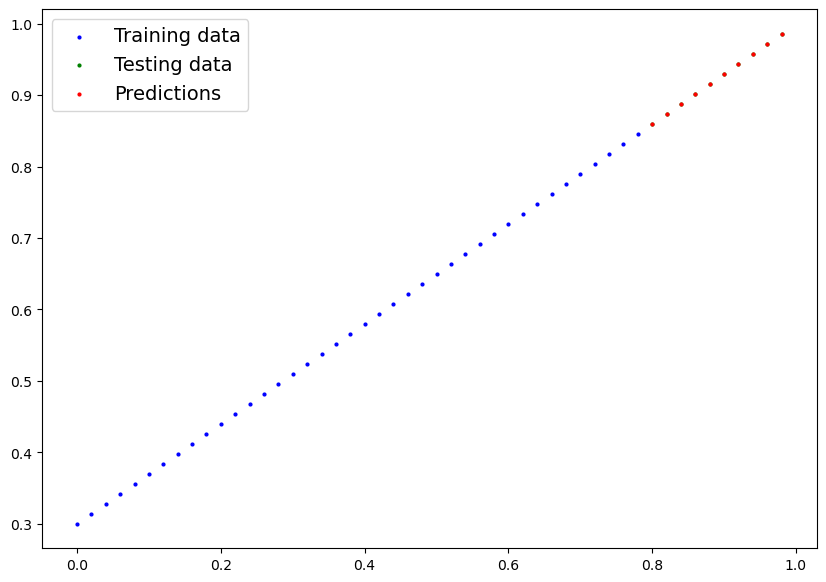

In [1049]:
plot_predictions(predictions=test_pred.cpu())

### Saving Model

In [1050]:
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_model_01.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\01_model_01.pth


### Loading Model

In [1052]:
loaded_model_1 = LinearRegressionModelV2()

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [1053]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### Verifying

In [1055]:
loaded_model_1.eval()

with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)

test_pred == loaded_model_1_preds


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')